In [1]:
import os
os.environ["HF_HOME"] = "/home/seungwoochoi/data/huggingface/cache"
from tqdm import tqdm
import torch
import torch.nn as nn
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from FlagEmbedding import BGEM3FlagModel
import numpy as np
import wandb
device = "cuda"
np.set_printoptions(threshold=np.inf)
import matplotlib.pyplot as plt

In [104]:
def spearman_corr(x: torch.Tensor, y: torch.Tensor) -> float:
    # Get ranks
    def rankdata(t):
        _, indices = torch.sort(t)
        ranks = torch.zeros_like(t, dtype=torch.float32)
        ranks = ranks.to(device)
        # print(ranks)
        ranks[indices] = torch.arange(1, len(t)+1).to(device, dtype=torch.float32)
        return ranks

    x_rank = rankdata(x)
    y_rank = rankdata(y)
    # print(x_rank)
    # print(y_rank)
    # Compute Pearson correlation on the ranks
    x_mean = x_rank.mean()
    y_mean = y_rank.mean()

    cov = ((x_rank - x_mean) * (y_rank - y_mean)).mean()
    std_x = x_rank.std(unbiased=False)
    std_y = y_rank.std(unbiased=False)
    # print(cov / (std_x * std_y))
    return (cov / (std_x * std_y)).item() #type:ignore

# Make Dataset

In [93]:
## LOAD PASSAGE EMBEDDINGS

passage_len = 100
passage_embedding = np.load("/home/seungwoochoi/data/axis_rag/data/ms_marco_embedding.npy")
passage_embedding = torch.from_numpy(passage_embedding)
print(passage_embedding.shape)
passage_embedding = passage_embedding.to("cuda")
passage_embedding = passage_embedding.to(torch.float32)

torch.Size([676193, 1024])


In [126]:
import numpy as np
from datasets import load_dataset

query_variation_list = []

#Load Query Dataset
with open("/home/seungwoochoi/data/axis_rag/data/word_list.txt",'r') as f:
    word_list = f.readlines()
    word_list = [x.strip() for x in word_list]

for word in word_list:
    tmp = [
    f"What is a {word}?",
    f"Can you explain what a {word} is?",
    # f"How would you define a {word}?",
    # f"What does the term {word} mean?",
    # f"Give me the definition of a {word}.",
    # f"Could you describe what a {word} is?",
    # f"What exactly is a {word}?",
    # f"Please tell me what a {word} is.",
    # f"Could you clarify the meaning of {word}?",
    # f"Explain the concept of a {word}.",
    # f"Could you explain a {word} to me?",
    # f"Give me an explanation of what a {word} is.",
    # f"What does the word {word} mean?",
    ]
    query_variation_list.append(tmp)

# Conduct Hadamard Product

In [127]:
embedding_model = BGEM3FlagModel('BAAI/bge-m3')

Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
def hadamard_product(vectors, eps=1e-12):
    X = np.array(vectors)
    # X = X * 100

    # 모든 벡터가 같은 부호인지 체크
    all_same_pos = np.all(X > 0, axis=0)
    all_same_neg = np.all(X < 0, axis=0)

    # 방향 부호
    dir_sign = np.where(all_same_pos, 1.0,
                        np.where(all_same_neg, -1.0, 0.0))

    # col_mean = X.mean(axis=0, keepdims=True)
    X = np.abs(X)
    # X = X - col_mean

    out = X[0].astype(float)

    for v in X[1:]:
        out = out * v        
        out /= (np.linalg.norm(out) + eps)  # 매 스텝 L2 정규화

    # out = out + col_mean
    # out /= (np.linalg.norm(out) + eps)
    # out = np.power(out, 1/X.shape[0])
    out = out * dir_sign
    # out = out / 100
    out /= (np.linalg.norm(out) + eps)
    # print(out)
    return out

def hadamard_sequential_geomean(vectors, eps=1e-12):
    X = np.array(vectors)
    # X = X * 100

    # 모든 벡터가 같은 부호인지 체크
    all_same_pos = np.all(X > 0, axis=0)
    all_same_neg = np.all(X < 0, axis=0)

    # 방향 부호
    dir_sign = np.where(all_same_pos, 1.0,
                        np.where(all_same_neg, -1.0, 0.0))

    # col_mean = X.mean(axis=0, keepdims=True)
    X = np.abs(X)
    # X = X - col_mean

    out = X[0].astype(float)

    for v in X[1:]:
        out = out * v                    # Hadamard 곱
        out = np.sqrt(out)
        out /= (np.linalg.norm(out) + eps)  # 매 스텝 L2 정규화

    # out = out + col_mean
    # out /= (np.linalg.norm(out) + eps)
    # out = np.power(out, 1/X.shape[0])
    out = out * dir_sign
    # out = out / 100
    out /= (np.linalg.norm(out) + eps)
    # print(out)
    return out

import numpy as np

def hadamard_geomean(vectors, eps=1e-12, sign_rule='zero_mismatch'):
    X = np.array(vectors, dtype=float)  # shape: (m, d)

    # col_mean = X.mean(axis=0, keepdims=True)
    # # X = np.abs(X)
    # X = X - col_mean

    # 부호 처리(옵션)
    if sign_rule == 'zero_mismatch':
        # 모든 벡터에서 같은 부호일 때만 부호 유지, 아니면 0
        all_pos = np.all(X > 0, axis=0)
        all_neg = np.all(X < 0, axis=0)
        sgn = np.where(all_pos, 1.0, np.where(all_neg, -1.0, 0.0))
    elif sign_rule == 'ignore':
        sgn = 1.0
    else:
        raise ValueError

    logmag = np.log(np.abs(X) + eps).mean(axis=0)   # 평균 로그 = 기하평균의 로그
    out = np.exp(logmag) * sgn                      # 기하평균
    out /= (np.linalg.norm(out) + eps)
    return out
    

In [128]:
from tqdm import tqdm

for i, query_variation in enumerate(query_variation_list[:]):
    query_embedding = embedding_model.encode(query_variation)['dense_vecs']
    # query_embedding = query_embedding - query_embedding.mean(axis=0, keepdims=True)
    query_embedding_x = hadamard_product(query_embedding)
    

    mat_for_visualization = np.concatenate((query_embedding, query_embedding_x[None,:]), axis=0)
    # print(len(mat_for_visualization))
    max_abs = np.max(np.abs(mat_for_visualization))
    plt.figure(figsize=(24, 6))
    im = plt.imshow(
        mat_for_visualization,
        cmap='bwr',                 # 음수=파랑, 양수=빨강
        aspect='auto',
        vmin=-max_abs,
        vmax= max_abs
    )

    plt.colorbar(im, label='Value')
    plt.title(f'Filtered Axis of {word_list[i]}')
    plt.xlabel('Dimension')
    plt.ylabel('Embedding')
    plt.savefig(f"/home/seungwoochoi/data/axis_rag/figure/axis_filtered/{word_list[i]}.png")
    plt.close()

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [137]:
spearman_corrs = []

for i, query_variation in tqdm(enumerate(query_variation_list[:])):
    query_embedding = embedding_model.encode(query_variation)['dense_vecs']
    # query_embedding = query_embedding - query_embedding.mean(axis=0, keepdims=True)
    query_embedding_x = hadamard_product(query_embedding)
    # print(query_embedding.shape)
    
    
    full_embedding = torch.tensor(query_embedding[0])
    full_embedding = full_embedding.to("cuda")
    full_embedding = full_embedding.to(torch.float32)

    full_scores = passage_embedding @ full_embedding
    # full_ranking = torch.argsort(full_scores,descending=True)
    # print(full_scores)
    # print(full_ranking.shape)

    selected_axes = np.argsort(np.abs(query_embedding_x))[:130]
    # print(selected_axes.shape)
    partial_passage_embedding = passage_embedding[:,selected_axes]
    partial_query_embedding = torch.tensor(np.array(query_embedding[0])[selected_axes]).to("cuda").to(torch.float32)

    partial_scores = partial_passage_embedding @ partial_query_embedding
    # partial_ranking = torch.argsort(partial_scores,descending=True)

    coef = spearman_corr(full_scores, partial_scores)

    # coef = np.corrcoef(np.array(full_ranking.to('cpu')), np.array(partial_ranking.to('cpu')))
    # print(coef[0,1])
    spearman_corrs.append(coef)

104it [00:08, 12.67it/s]


In [138]:
np.mean(spearman_corrs)

np.float64(0.08941806194511279)

In [ ]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# Assuming query_variation_list, embedding_model, hadamard_product, 
# and word_list are defined.

for i, query_variation in enumerate(query_variation_list[:]):
    query_embedding = embedding_model.encode(query_variation)['dense_vecs']
    # query_embedding = query_embedding - query_embedding.mean(axis=0, keepdims=True)
    query_embedding_x = hadamard_product(query_embedding)
    

    mat_for_visualization = np.concatenate((query_embedding, query_embedding_x[None,:]), axis=0)
    # print(len(mat_for_visualization))
    max_abs = np.max(np.abs(mat_for_visualization))
    plt.figure(figsize=(24, 6))
    im = plt.imshow(
        mat_for_visualization,
        cmap='bwr',                 # 음수=파랑, 양수=빨강
        aspect='auto',
        vmin=-max_abs,
        vmax= max_abs
    )

    # --- Change is here ---
    # Set the y-axis ticks to match the indices of the matrix rows
    plt.yticks(np.arange(mat_for_visualization.shape[0]))

    plt.colorbar(im, label='Value')
    plt.title(f'Filtered Axis of {word_list[i]}')
    plt.xlabel('Dimension')
    plt.ylabel('Matrix Index') # Updated label for clarity
    plt.savefig(f"/home/seungwoochoi/data/axis_rag/figure/axis_filtered/{word_list[i]}.png")
    plt.close()

4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


KeyboardInterrupt: 

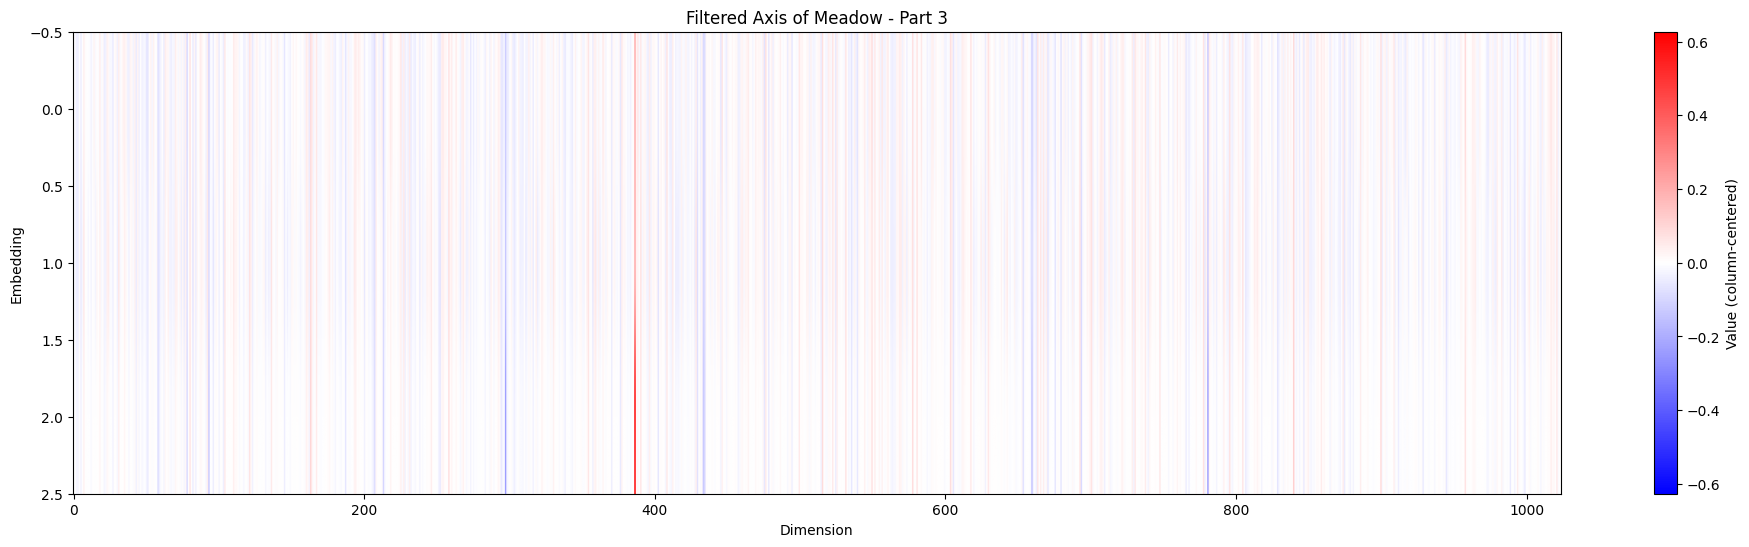

In [105]:
import numpy as np
import matplotlib.pyplot as plt

for i, query_variation in enumerate(query_variation_list[:10]):  # 첫 번째 query_variation만
    query_embedding = embedding_model.encode(query_variation)['dense_vecs']

    # 등분
    n_splits = 2
    split_size = len(query_embedding) // n_splits

    for split_idx in range(len(query_variation)-1):
        # start = split_idx * split_size
        # end = (split_idx + 1) * split_size if split_idx < n_splits - 1 else len(query_embedding)

        query_embedding_split = query_embedding[split_idx:split_idx+2]
        query_embedding_x = hadamard_product(query_embedding_split)

        mat_for_visualization = np.concatenate((query_embedding_split, query_embedding_x[None, :]), axis=0)
        max_abs = np.max(np.abs(mat_for_visualization))

        plt.figure(figsize=(24, 6))
        im = plt.imshow(
            mat_for_visualization,
            cmap='bwr',
            aspect='auto',
            vmin=-max_abs,
            vmax=max_abs
        )
        plt.colorbar(im, label='Value (column-centered)')
        plt.title(f'Filtered Axis of {word_list[i]} - Part {split_idx+1}')
        plt.xlabel('Dimension')
        plt.ylabel('Embedding')

        plt.savefig(f"/home/seungwoochoi/data/axis_rag/figure/axis_filtered/{word_list[i]}_part{split_idx+1}.png")
        plt.close()

In [6]:
for i, query_variation in enumerate(query_variation_list[:1]):
    query_embedding = embedding_model.encode(query_variation)['dense_vecs']
    # query_embedding = query_embedding - query_embedding.mean(axis=0, keepdims=True)
    query_embedding_x = hadamard_product(query_embedding)

    mat_for_visualization = np.concatenate((query_embedding, query_embedding_x[None,:]), axis=0)
    max_abs = np.max(np.abs(mat_for_visualization))
    plt.figure(figsize=(24, 6))
    im = plt.imshow(
        mat_for_visualization,
        cmap='bwr',                 # 음수=파랑, 양수=빨강
        aspect='auto',
        vmin=-max_abs,
        vmax= max_abs
    )

    plt.colorbar(im, label='Value (column-centered)')
    plt.title(f'Filtered Axis of {word_list[i]}')
    plt.xlabel('Dimension')
    plt.ylabel('Embedding')
    plt.savefig(f"/home/seungwoochoi/data/axis_rag/figure/axis_filtered/{word_list[i]}.png")
    plt.close()

104


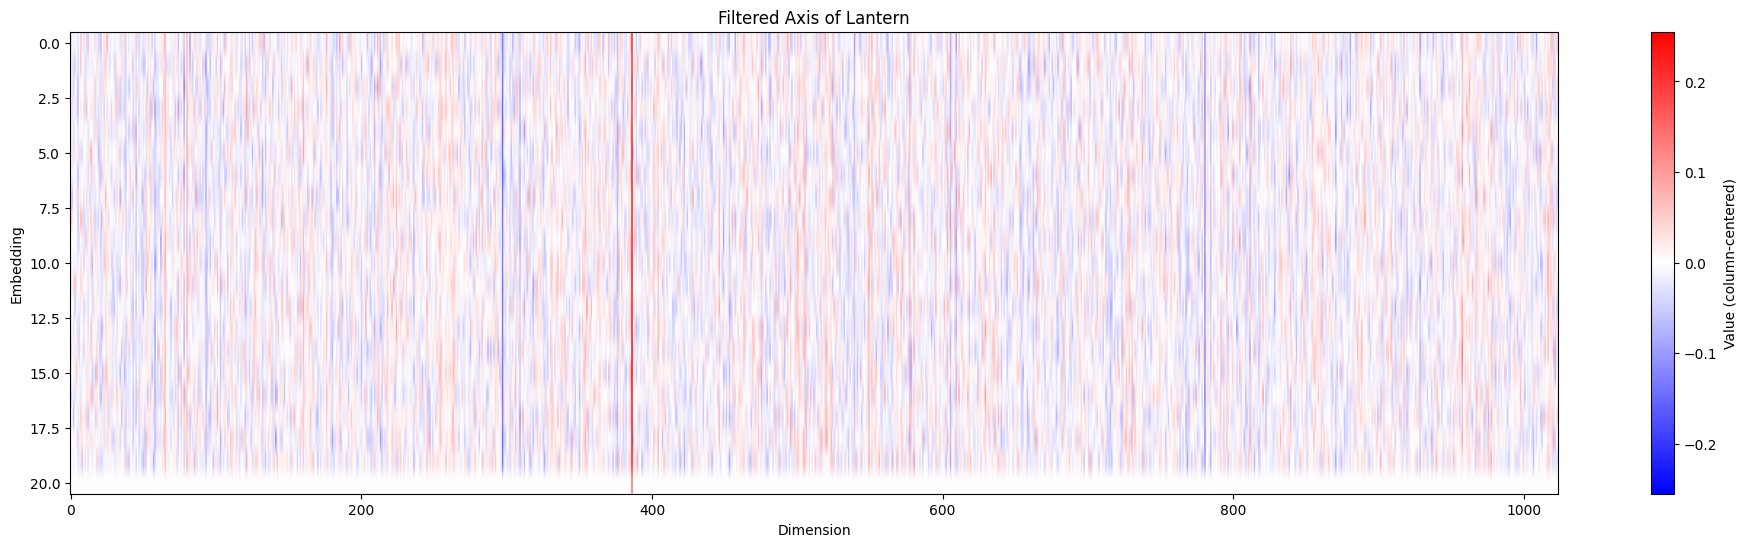

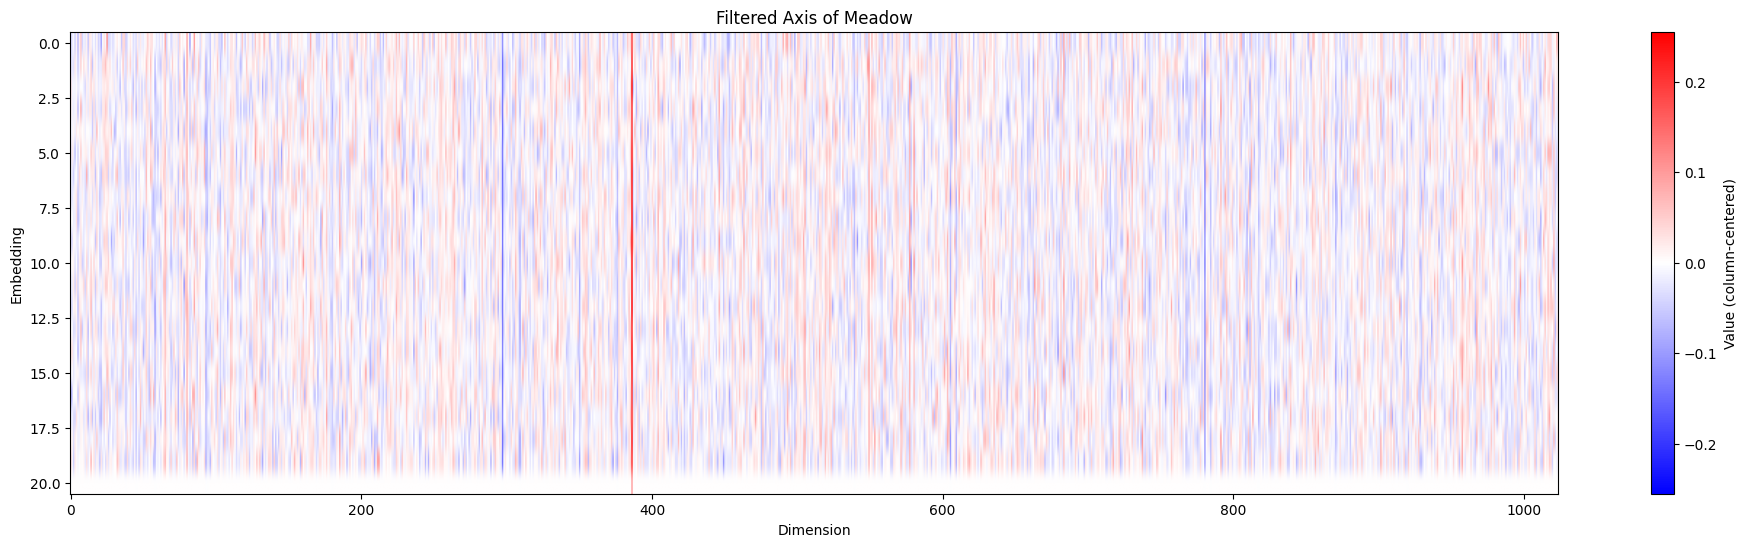

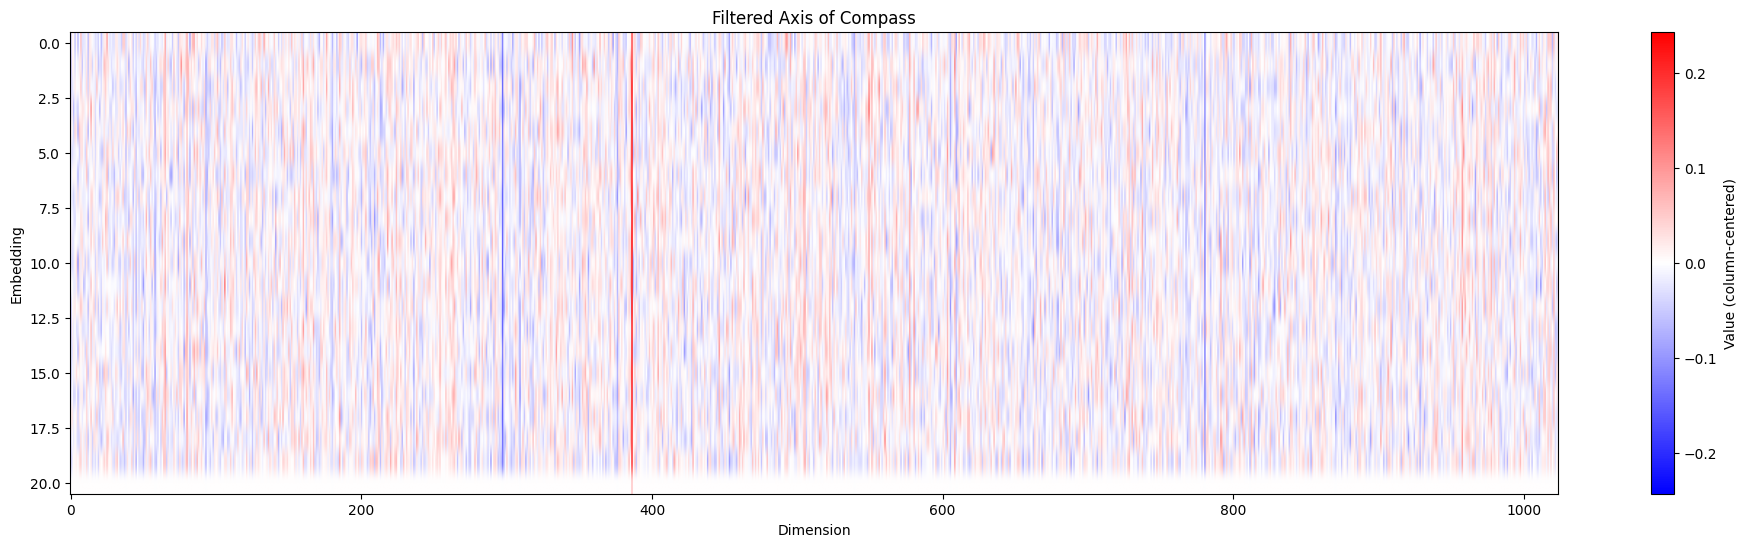

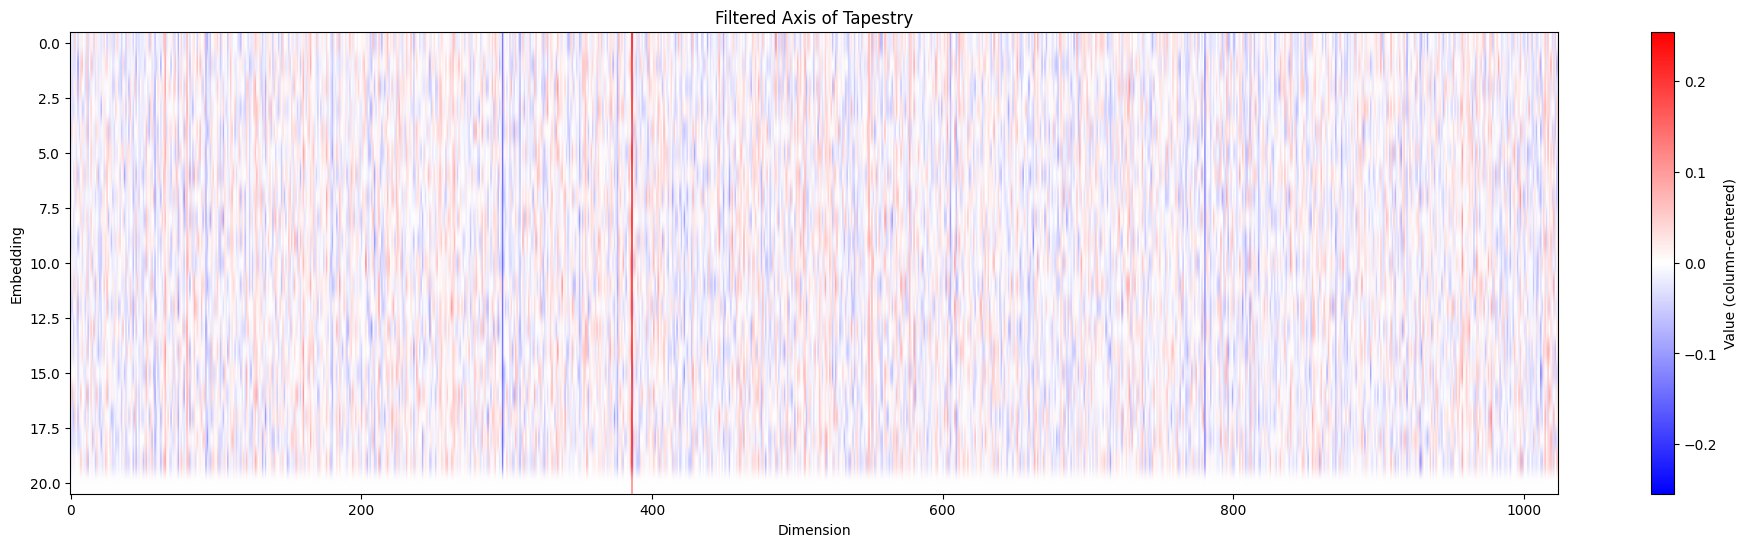

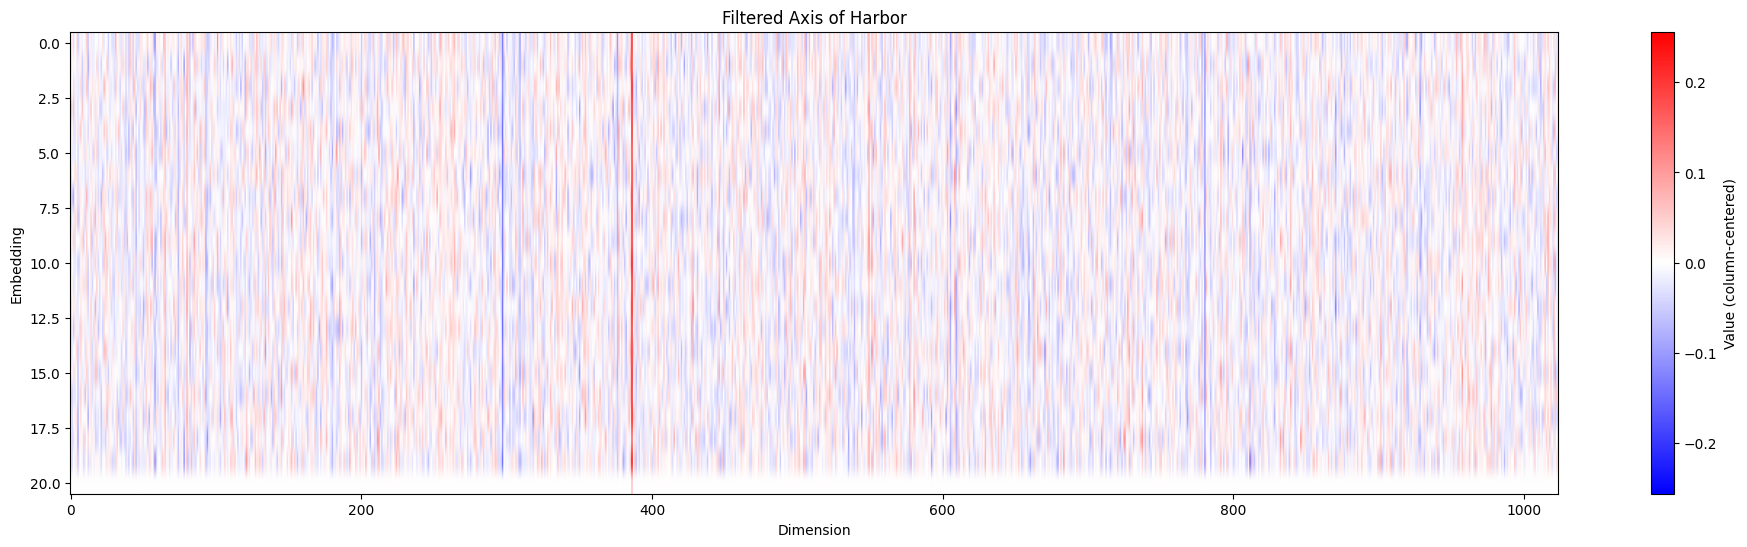

In [13]:
query_list = [x[0] for x in query_variation_list]
print(len(query_list))
for i in range(5):
    # print(query_list[i*10:(i+1)*10])
    query_embedding = embedding_model.encode(query_list[i*20:(i+1)*20])['dense_vecs']
    
    query_embedding_x = hadamard_product(query_embedding)

    mat_for_visualization = np.concatenate((query_embedding, query_embedding_x[None,:]), axis=0)
    max_abs = np.max(np.abs(mat_for_visualization))
    plt.figure(figsize=(24, 6))
    im = plt.imshow(
        mat_for_visualization,
        cmap='bwr',                 # 음수=파랑, 양수=빨강
        aspect='auto',
        vmin=-max_abs,
        vmax= max_abs
    )

    plt.colorbar(im, label='Value (column-centered)')
    plt.title(f'Filtered Axis of {word_list[i]}')
    plt.xlabel('Dimension')
    plt.ylabel('Embedding')
    # plt.savefig(f"/home/seungwoochoi/data/axis_rag/figure/axis_filtered/{word_list[i]}.png")
    plt.show()
    plt.close()


# Similar Query Analysis

In [2]:
embedding_model = BGEM3FlagModel('BAAI/bge-m3')

Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

In [23]:
sim_query_embeddings = embedding_model.encode(["What is a Throne?", "What does a Throne mean?", "Tell me the meaning of a Throne.", "What is a Trophy?", "What does a Trophy means?", "Tell me the meaning of a Trophy."])['dense_vecs']

print(sim_query_embeddings[0] @ sim_query_embeddings[1])
print(sim_query_embeddings[0] @ sim_query_embeddings[2])
print(sim_query_embeddings[0] @ sim_query_embeddings[3])
print(sim_query_embeddings[0] @ sim_query_embeddings[4])
print(sim_query_embeddings[0] @ sim_query_embeddings[5])

print(np.argsort(sim_query_embeddings[0] * sim_query_embeddings[1])[-20:])
print(np.argsort(sim_query_embeddings[0] * sim_query_embeddings[2])[-20:])
print(np.argsort(sim_query_embeddings[0] * sim_query_embeddings[3])[-20:])
print(np.argsort(sim_query_embeddings[0] * sim_query_embeddings[4])[-20:])
print(np.argsort(sim_query_embeddings[0] * sim_query_embeddings[5])[-20:])


0.9517
0.832
0.6436
0.6177
0.552
[ 254  463  605  309  915  577  549  487  957  236  206  603    5 1020
  515  728  679  780  297  386]
[ 915  737  605  309  679  218  515  487  463    5  236  603  206  728
  577 1020  549  780  297  386]
[ 124 1020  238   80  539  428   65  560  603  422  870  577  728  463
  549  605  957  780  297  386]
[   5  505  238  487  428  737  463  349  870  422  728 1020  603  577
  605  549  957  780  297  386]
[ 206  935  331  376  728  870   80  428  737  603    5   65  463  605
 1020  577  549  780  297  386]
